# The effect of belief interaction on group polarization in networked experiments

Preregistration of analysis code

Todo:
- [x] confidence intervals for game-level measures
- [ ] SEM mediation analysis
- [ ] correlation plot / regression calc btw. game-level imitation difference + pl2 difference and outcome measure difference
- [x] why does startup fixed-effect absorb zero variance? -> very few samples


In [1]:
%pylab inline
%load_ext rpy2.ipython

# for managing data
import pandas as pd
import networkx as nx
import json
from collections import Counter
import itertools
import copy
from datetime import datetime
import scipy.stats as stats

#from lifelines import CoxTimeVaryingFitter # - we'll use R's "survival" package instead
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances as pwdist

import string

Populating the interactive namespace from numpy and matplotlib


### Load data from experiment database

In [2]:
export_dir = "../results-sensitive/pilot/20200225/json/"
players = []
with open(export_dir + 'players.json', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.json', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.json', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.json', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'], game['gameSetupId'])

0 2019-11-27T18:20:38.972Z panel_0_matched_pair_exp_design5_matched_20191125_173028
1 2019-12-11T17:08:10.631Z panel_0_matched_pair_exp_design5_matched_20191211_112322
2 2019-12-11T18:21:08.701Z panel_0_matched_pair_exp_design5_matched_20191211_112322
3 2019-12-18T15:21:44.815Z test
4 2019-12-18T15:58:20.952Z small
5 2020-01-16T17:36:13.359Z panel_1_matched_pair_exp_design5_matched_20191211_112322
6 2020-02-24T18:08:42.538Z solotest
7 2020-02-24T18:20:09.033Z solotest
8 2020-02-24T18:56:53.687Z 1player_39bots
9 2020-02-25T18:59:30.743Z testsolo6
10 2020-02-25T18:59:52.865Z testsolo6
11 2020-02-25T20:36:00.288Z panel_0_matched_pair_caveman_exp_design6_matched_20200224_122320
12 2020-02-25T20:36:39.337Z panel_0_matched_pair_exp_design6_matched_20200224_122320


In [3]:
# select which games to process
# Game 1 (2019-12-11T17:08:10.631Z) was a test game, for practice
# Games 3+4 (2019-12-18) failed demo games

select = [0, 2, 5, 11, 12]
#select = [2, 5, 12]
#select = [12]
process_games = [loaded_games[i] for i in select]

for game in process_games:
    print(game['createdAt'], game['gameSetupId'])

2019-11-27T18:20:38.972Z panel_0_matched_pair_exp_design5_matched_20191125_173028
2019-12-11T18:21:08.701Z panel_0_matched_pair_exp_design5_matched_20191211_112322
2020-01-16T17:36:13.359Z panel_1_matched_pair_exp_design5_matched_20191211_112322
2020-02-25T20:36:00.288Z panel_0_matched_pair_caveman_exp_design6_matched_20200224_122320
2020-02-25T20:36:39.337Z panel_0_matched_pair_exp_design6_matched_20200224_122320


In [58]:
select = [11]
#select = [2, 5, 12]
caveman_games = [loaded_games[i] for i in select]

for game in caveman_games:
    print(game['createdAt'], game['data.gameSetupId'])

2020-02-25T20:36:00.288Z panel_0_matched_pair_caveman_exp_design6_matched_20200224_122320


In [4]:
### this block includes one of the previous games that used a different format for log

export_dir = "../results-sensitive/pilot/20191001/Empirica Data - 2019-10-01 18-28-44/"
players = []
with open(export_dir + 'players.json', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.json', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.json', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

experiment_filepath = "../setup/games/exp_design4_matched_20190925_121500.json"
with open(experiment_filepath, 'r') as f:
    experiment = json.load(f)
    

# match games, players, experiment data
experiment_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    
    if game['gameSetupId'] in experiment['games'].keys():
        game['gameData'] = experiment['games'][game['gameSetupId']]
        game['data.clues'] = experiment['games'][game['gameSetupId']]['clues']
        experiment_games.append(game)
        print('%s loaded' %game['gameSetupId'])
    else:
        print('%s not in experiment' % game['gameSetupId'])
        
process_games.append(experiment_games[-1])


panel_1_matched_pair_exp_design3_matched_20190723_115409 not in experiment
panel_0_matched_pair_exp_design3_matched_20190723_115409 not in experiment
panel_0_matched_pair_exp_design3_matched_20190723_115409 not in experiment
panel_0_matched_pair_exp_design3_matched_20190726_115504 not in experiment
panel_0_matched_pair_exp_design4_matched_20190925_121500 loaded
panel_0_matched_pair_exp_design4_matched_20190925_121500 loaded


### Calculate Continuous-Time Measures

In [70]:
def retrace(game):
    """
    Uses the game log and starting conditions to recreate the state of the
    game at every change event.
    
    Returns a generator yielding (player_id, g, t) at each event in the game,

    *player_id* is the player logging the event,
    *g* is the state of the game following the event,
    *t* timestamp in seconds since game start

    Does not return an action if the only change is a list reordering.
    """
    clues = game['data.clues']
    
    # create trace social network
    edge_list = []
    for player_id, player_data in game['players'].items():
        for alter_id in player_data['data.alterIDs']:
            edge_list.append([player_id, alter_id])
    g = nx.from_edgelist(edge_list)

    # give trace players starting information
    nx.set_node_attributes(
        g,
        name='pos',  # position in the social network
        values={a: game['players'][a]['data.position'] for a in g}
    )

    nx.set_node_attributes(
        g,
        name='M',  # M for mind/memory
        values={a: nx.from_edgelist([
            clues[bf]['nodes'] for bf in
            game['players'][a]['data.initialState']['promising_leads']['clueIDs']
        ]) for a in g}
    )

    nx.set_node_attributes(
        g,
        name='F',  # F for forgetory
        values={i: nx.Graph() for i in g}
    )

    # yield the initial state of the experiment
    yield (None, g, 0)


    # trace game
    t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')

    for event in game['log']:
        if event['name'] != 'drop': # only consider drop events
            continue
            
        player_id = event["playerId"]
        source = event['data']['source']
        dest = event['data']['dest']
        if 'clue' in event['data']:
            if event['data']['clue'] != None:
                edge = clues[event['data']['clue']]['nodes']
            else: # catch incomplete record
                print('Missing clueID for player %s from source %s at time %s' % (player_id, source, event['at']))
        else:
            print('player %s is missing a clue' % player_id)
            continue
        M = g.nodes()[player_id]['M']
        F = g.nodes()[player_id]['F']
        update = False

        if source == "promising_leads":
            assert g.nodes()[player_id]['M'].has_edge(*edge) # check that clue is still in memory
            if dest == "dead_ends":
                M.remove_edge(*edge)
                F.add_edge(*edge)
                update = True

        elif source == "dead_ends":
            assert g.nodes()[player_id]['F'].has_edge(*edge) # check that clue is still in forgettory
            if dest == "promising_leads":
                F.remove_edge(*edge)
                M.add_edge(*edge)
                update = True

        else:
            assert source in game['playerIds']  # check that source is another player
            if not g.nodes()[source]['M'].has_edge(*edge):  # check that clue is in source
                # this can fail if the exposer removes the clue while the exposed is dragging it.
                # turns out not to be a big deal
                print("%s no longer in source %s" % (str(edge), str(source)))
            if dest == "promising_leads":
                M.add_edge(*edge)
                if F.has_edge(*edge):
                    F.remove_edge(*edge)
                update = True
            elif dest == "dead_ends":
                F.add_edge(*edge)
                if M.has_edge(*edge):
                    M.remove_edge(*edge)
                update = True
            assert not (F.has_edge(*edge) and  # not in both memory and forgetery
                        M.has_edge(*edge))

        if update:
            t_current = datetime.strptime(event['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            t = (t_current - t_start).total_seconds()
            yield (player_id, g, t)

    # double check the final state at the end of the generator
    for player_id in g:
        leads = game['players'][player_id]['data.notebooks']['promising_leads']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in leads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['M'].edges()])
        assert should_have == has

        deads = game['players'][player_id]['data.notebooks']['dead_ends']['clueIDs']
        should_have = set([tuple(sorted(clues[clue]['nodes'])) for clue in deads if clue != None])
        has = set([tuple(sorted(edge)) for edge in g.nodes()[player_id]['F'].edges()])
        assert should_have == has
       

In [69]:
def compute_adoption_hazard_table(game):
    """
    All of the steps to compute the hazard tables for use in cox regressions
    """
    
    def instantaneous_hazard_factors(game, g, t):
        """
        Given the state of the game, what are the factors that lead to adoption?

        Returns a row for the hazard factors of all individuals adopting all beliefs 
        at the time of the event, so this gets big fast (!!?!!!!)
        """
        startup_period = 30  # (seconds) the time individuals spend acclimatizing at game start

        rows = [] # one row for each individual*belief pair
        players = game['players']
        hub_elements = {game['data.nodes']['CrimeScene_1'], game['data.nodes']['StolenObject_1']}
        clue_ids = list(game['data.clues'])
        
        # Define clues used in polarization analysis
        # final clues used in analysis are connections between hub nodes (1,2) and rim nodes (3-13)
        t_spokes = ['tclue_1_3', 'tclue_1_4', 'tclue_1_5', 'tclue_1_6', 'tclue_1_7', 
                    'tclue_1_8', 'tclue_1_9', 'tclue_1_10','tclue_1_11', 'tclue_1_12', 'tclue_1_13',
                    'tclue_2_3', 'tclue_2_4', 'tclue_2_5', 'tclue_2_6', 'tclue_2_7',
                    'tclue_2_8', 'tclue_2_9', 'tclue_2_10', 'tclue_2_11', 'tclue_2_12', 'tclue_2_13']

        c_spokes = ['cclue_1_3', 'cclue_1_4', 'cclue_1_5', 'cclue_1_6', 'cclue_1_7', 
                    'cclue_1_8', 'cclue_1_9', 'cclue_1_10','cclue_1_11', 'cclue_1_12', 'cclue_1_13',
                    'cclue_2_3', 'cclue_2_4', 'cclue_2_5', 'cclue_2_6', 'cclue_2_7',
                    'cclue_2_8', 'cclue_2_9', 'cclue_2_10', 'cclue_2_11', 'cclue_2_12', 'cclue_2_13']
        
        spoke_clue_ids = t_spokes+c_spokes
        spoke_edges = [game['data.clues'][clue_id]['nodes'] for clue_id in spoke_clue_ids]

        game_id = game['createdAt'].split('_')[0].replace('-','_').replace(':','_').replace('.','_')
        for player_id in players:
            position = players[player_id]['data.position']
            neighbors = g.neighbors(player_id)
            M = copy.deepcopy(g.nodes()[player_id]['M'])  # promising leads (memory)
            F = copy.deepcopy(g.nodes()[player_id]['F'])  # dead ends (forgetory)

            neighbor_clues = {nb: [] for nb in neighbors}
            exposers = {clue_id: [] for clue_id in clue_ids}
            player_leads = []
            player_deads = []
            for clue_id in clue_ids:
                if clue_id[0] != position[0]: # only collect treatment clues for treatment players, vice versa
                    continue 
                edge = game['data.clues'][clue_id]['nodes']
                if M.has_edge(*edge):
                    player_leads.append(clue_id)
                if F.has_edge(*edge):
                    player_deads.append(clue_id)

                for nb in g.neighbors(player_id):
                    if g.nodes()[nb]['M'].has_edge(*edge):
                        neighbor_clues[nb].append(clue_id)
                        exposers[clue_id].append(nb)

            fresh_candidates = set([cl for cl, exps in exposers.items() if len(exps) > 0]) - set(player_leads) - set(player_deads)    
            n_fresh_candidates = len(fresh_candidates)

            n_existing_beliefs = len(player_leads)


            # Removing the central clue means that we're only going to count logical interactions
            # that go via one of the other spoke clues. Under control conditions there should never 
            # be a logical interaction. I do this after counting the number of existing beliefs.
            if M.has_edge(*tuple(hub_elements)):
                M = copy.deepcopy(M)  # may not need this copy? we copy above..
                M.remove_edge(*tuple(hub_elements)) # ignore the clue linking the crime scene to stolen object


            for clue_id in spoke_clue_ids:
                if clue_id[0] != position[0]: # only collect treatment clues for treatment players, vice versa
                    continue 

                edge = game['data.clues'][clue_id]['nodes']
                rim_node = (set(edge) - hub_elements).pop()

                row = {'game_player_clue_id': "%s_%s_%s" % (game_id, position, clue_id),
                       'game_player_id': "%s_%s" % (game_id, position),
                       'game_id': "%s"% game_id,
                       'start': t,
                       'treatment': position.startswith('t'),
                       'have_belief': clue_id in player_leads,
                       'in_deads': clue_id in player_deads,
                       'n_exposures': len(exposers[clue_id]),
                       'n_existing_beliefs':n_existing_beliefs,
                       'n_fresh_candidates': n_fresh_candidates,
                       'player_clues': player_leads,
                       'startup': t<=startup_period,
                      }

                # number of times the rim element is referenced in the existing belief set
                if set(edge) == hub_elements:
                    row['references'] = np.nan
                else:
                    row['references'] = len(M.edges(rim_node))


                # count of paths player has connecting ends of clue
                path_list = nx.all_simple_paths(M, *edge, cutoff=2) if set(edge)<set(M.nodes()) else []
                path_counts = pd.Series(pd.Series([len(pth) - 1 for pth in path_list]).value_counts(),
                                        index=range(1, 5)).fillna(0)
                row['pl2'] = path_counts[2]

                row['exposers_clues'] = {nb: cls for nb, cls in neighbor_clues.items() if nb in exposers[clue_id]}

                rows.append(row)

        return rows
    
    def drop_consecutive_duplicates(df, cols, sort_on):
        """if nothing changes for a player's clue adoption likelihood, condense the hazard table"""
        df = df.sort_values('start')
        return df.loc[any(df.shift(-1)[cols] != df[cols], axis=1).shift(+1).fillna('True').astype(bool)]

    def add_stops(df, t_last):
        df['stop'] = df['start'].shift(-1)
        df.loc[df.index[-1], 'stop'] = t_last
        return df

    def similarity_func(player_clues, alter_clues):
        """
        Coverage: fraction of alter's total clues that player holds
        
        This is relevant for adoption cascades, as if the individual holds
        beliefs that are similar to what made the exposing individual adopt,
        they are more likely to have drivers for adoption.
        """
        return len(set(player_clues) & set(alter_clues)) / len(alter_clues)


    def process_adoption_group(group):
        """
        Groups represent player-clue combinations
        Takes the hazard table and creates a table that lifelines can use.
        1. Condenses multiple rows (by dropping duplicates)
        2. Treats start and end times
        3. Identifies adoption events
        """
        
        # discard player-clue groups where the player is exposed at start
        # these don't represent adoption decisions by exposer, so we can't expect
        # there to be correlation between this exposer and adopters
        t_first_exposure = group[group['n_exposures']>0]['start'].min()
        if t_first_exposure < 1:  # give a 1 second buffer on start time synchronization
             return pd.DataFrame()

        # discard player-clue groups where the player is never exposed to the clue
        if max(group['n_exposures']) == 0: 
            return pd.DataFrame()
        
        # make sure group is sorted so we can iterate in order
        group.sort_values(['start'], inplace=True)
        
        # calculate instantaneous max similarity to exposer
        max_similarity_to_exposer = []  
        exposer_exposure_beliefs = {}  # beliefs exposer held at the time of exposure
        for i, row in group.iterrows():
            # add exposers to dictionary as their exposure event happens
            for exposer, clues in group.loc[i]['exposers_clues'].items():
                if exposer not in exposer_exposure_beliefs:  # new exposure
                    exposer_exposure_beliefs[exposer] = clues
            
            # calculate current max similarity to exposer for this row
            if len(row['exposers_clues']) == 0:  # no exposures yet
                max_similarity_to_exposer.append(-1000)  # this should be nan, but the drop duplicates can't handle that
            else:
                similarities = [similarity_func(row['player_clues'], exposer_exposure_beliefs[exposer])
                                for exposer in row['exposers_clues']]
                max_similarity_to_exposer.append(np.max(similarities))
        group['max_similarity_to_exposer'] = max_similarity_to_exposer
            
        # filter out rows that don't change the regressors 
        regressors = ['n_exposures', 'max_similarity_to_exposer', 'have_belief', 
                      'references', 'pl2', 'n_existing_beliefs', 'in_deads', 
                      'n_fresh_candidates', 'startup']
        
        fgroup = drop_consecutive_duplicates(
            df=group, 
            cols=regressors, 
            sort_on='start'
        )
        
        # add period stops
        t_final = datetime.strptime(game['finishedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        t_start = datetime.strptime(game['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        total_time = (t_final-t_start).total_seconds()
        fgroup = add_stops(fgroup, total_time)

        # add adopting events
        fgroup['adopt_event'] = fgroup['have_belief'] < fgroup.shift(-1)['have_belief']
        fgroup.loc[fgroup.index[-1], 'adopt_event'] = False

        # add forgetting events
        fgroup['forget_event'] = fgroup['have_belief'] > fgroup.shift(-1)['have_belief']
        fgroup.loc[fgroup.index[-1], 'forget_event'] = False

        
        return_cols = regressors + [
            'treatment', 'game_player_clue_id', 'game_player_id', 'game_id',
            'start', 'stop', 'adopt_event', 'forget_event'
        ] 
        return fgroup[return_cols]


    hazard_factors_list = []
    for (player_id, g, t) in retrace(game):
        hazard_factors_list += instantaneous_hazard_factors(game, g, t)
    unprocessed_hazard_table = pd.DataFrame(hazard_factors_list)
    unprocessed_hazard_table.sort_values(['game_player_clue_id', 'start'], inplace=True)
    
    res_list = []
    for i, group in unprocessed_hazard_table.groupby('game_player_clue_id'):
        res_list.append(process_adoption_group(group))
    hazard_table = pd.concat(res_list)
    
    # interact each measure with the treatment dummy to get a regressor on the 
    # difference between treatment and control
    hazard_table['treatment_n_exposures'] = hazard_table['treatment']*hazard_table['n_exposures']
    hazard_table['treatment_references'] = hazard_table['treatment']*hazard_table['references']
    hazard_table['treatment_pl2'] = hazard_table['treatment']*hazard_table['pl2']
    hazard_table['treatment_n_existing_beliefs'] = hazard_table['treatment']*hazard_table['n_existing_beliefs']
    hazard_table['treatment_n_fresh_candidates'] = hazard_table['treatment']*hazard_table['n_fresh_candidates']
    hazard_table['treatment_max_similarity_to_exposer'] = hazard_table['treatment']*hazard_table['max_similarity_to_exposer']
    hazard_table['treatment_in_deads'] = hazard_table['treatment']*hazard_table['in_deads']*1.0

    # only look at potential adoptions
    adoption_hazard_table = hazard_table[(hazard_table['have_belief']==0) & (hazard_table['n_exposures'] > 0)]
    adoption_hazard_table['adopt_event'] *= 1.0 # force to float
    adoption_hazard_table.reset_index(drop=True, inplace=True)

    return adoption_hazard_table
    

    

In [ ]:
aht_collector = [compute_adoption_hazard_table(game) for game in process_games]
aht = pd.concat(aht_collector)
    
# add game dummies for mediation analysis
dummies = pd.get_dummies(aht['game_id'], prefix='game')
interacted_dummies = pd.DataFrame(index=dummies.index)
for col in dummies.columns:
    interacted_dummies['mse_'+col] = dummies[col]*aht['max_similarity_to_exposer']
    interacted_dummies['treatment_mse_'+col] = dummies[col]*aht['treatment']*aht['max_similarity_to_exposer']
    interacted_dummies['control_mse_'+col] = dummies[col]*(1-aht['treatment'])*aht['max_similarity_to_exposer']
    
aht = pd.concat([aht, interacted_dummies], axis=1)
dummy_cols = dummies.columns # use later in recovering the game-level effects in r4

datafilename = "adoption_hazard_table.csv"
aht.to_csv(datafilename)

In [71]:
aht_collector = [compute_adoption_hazard_table(game) for game in caveman_games]
aht = pd.concat(aht_collector)
    
# add game dummies for mediation analysis
dummies = pd.get_dummies(aht['game_id'], prefix='game')
interacted_dummies = pd.DataFrame(index=dummies.index)
for col in dummies.columns:
    interacted_dummies['mse_'+col] = dummies[col]*aht['max_similarity_to_exposer']
    interacted_dummies['treatment_mse_'+col] = dummies[col]*aht['treatment']*aht['max_similarity_to_exposer']
    interacted_dummies['control_mse_'+col] = dummies[col]*(1-aht['treatment'])*aht['max_similarity_to_exposer']
    
aht = pd.concat([aht, interacted_dummies], axis=1)
dummy_cols = dummies.columns # use later in recovering the game-level effects in r4

datafilename = "caveman_adoption_hazard_table.csv"
aht.to_csv(datafilename)

['Moore', 'a motorcycle helmet'] no longer in source gpZspo4BMkvAseucJ
['Moore', '38'] no longer in source W62nrytMGhSPABEze


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

In [35]:
aht['startup'].value_counts()

False    17562
True        23
Name: startup, dtype: int64

In [44]:
!say "hazard rate factors calculation complete James come and check it please"

# First cox regression

In [32]:
%%R -i datafilename -o r1_summary -o r1_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty

# This regression calculates parameters for all experiments together, and is 
# not used for the mediation analysis pieces


library(survival)
df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


r1_fit <- coxph(Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
      n_exposures + references + n_existing_beliefs + n_fresh_candidates + in_deads + 
      treatment_n_exposures + treatment_pl2 + treatment_references + treatment_n_existing_beliefs +
      treatment_n_fresh_candidates + treatment_in_deads +
      startup + frailty.gaussian(game_player_id),
      data=df)

print(r1_fit)

r1_summary = summary(r1_fit)
print(r1_summary)

Call:
coxph(formula = Surv(time = start, time2 = stop, event = adopt_event, 
    type = "counting") ~ n_exposures + references + n_existing_beliefs + 
    n_fresh_candidates + in_deads + treatment_n_exposures + treatment_pl2 + 
    treatment_references + treatment_n_existing_beliefs + treatment_n_fresh_candidates + 
    treatment_in_deads + startup + frailty.gaussian(game_player_id), 
    data = df)

                               coef  se(coef)       se2     Chisq   DF       p
n_exposures                 0.37949   0.14246   0.13932   7.09611  1.0  0.0077
references                  0.39842   0.07014   0.06834  32.26385  1.0 1.3e-08
n_existing_beliefs          0.00851   0.02373   0.02078   0.12876  1.0  0.7197
n_fresh_candidates         -0.11635   0.01845   0.01620  39.77808  1.0 2.8e-10
in_deadsTrue               -1.90204   0.27999   0.27464  46.14950  1.0 1.1e-11
treatment_n_exposures       0.20359   0.20290   0.19669   1.00689  1.0  0.3156
treatment_pl2               0.24674   0.119

In [33]:
r1_summary_dict = dict(zip(r1_summary.names, r1_summary))
r1 = pd.concat(
    [pd.DataFrame(data=np.array(r1_summary_dict['coefficients']), columns=['coef', 'se(coef)', 'se2', 'Chisq', 'DF', 'p']),
     pd.DataFrame(data=np.array(r1_summary_dict['conf.int']), columns=['exp(coef)', 'exp(-coef)', 'lower .95', 'upper .95'])],
    axis=1)
r1.index = r1_fit[15].names
r1

,coef,se(coef),se2,Chisq,DF,p,exp(coef),exp(-coef),lower .95,upper .95
n_exposures,0.379493,0.142460,0.139321,7.096105,1.000000,7.725164e-03,1.461543,0.684208,1.105476,1.932297
references,0.398419,0.070143,0.068341,32.263855,1.000000,1.345939e-08,1.489469,0.671380,1.298153,1.708980
n_existing_beliefs,0.008514,0.023727,0.020775,0.128755,1.000000,7.197259e-01,1.008550,0.991522,0.962723,1.056559
n_fresh_candidates,-0.116352,0.018448,0.016197,39.778082,1.000000,2.845202e-10,0.890162,1.123391,0.858551,0.922937
in_deads,-1.902043,0.279986,0.274644,46.149495,1.000000,1.095652e-11,0.149263,6.699570,0.086224,0.258391
treatment_n_exposures,0.203594,0.202896,0.196693,1.006891,1.000000,3.156487e-01,1.225800,0.815794,0.823596,1.824420
treatment_pl2,0.246739,0.119154,0.117007,4.288012,1.000000,3.838202e-02,1.279845,0.781345,1.013288,1.616522
treatment_references,-0.083988,0.098057,0.095765,0.733631,1.000000,3.917087e-01,0.919442,1.087616,0.758679,1.114271
treatment_n_existing_beliefs,-0.053609,0.020548,0.018609,6.806951,1.000000,9.080367e-03,0.947802,1.055072,0.910390,0.986752
treatment_n_fresh_candidates,0.018364,0.018475,0.016222,0.988014,1.000000,3.202282e-01,1.018534,0.981803,0.982312,1.056092


### Assess M0 manipulation check

In [36]:
if (all(aht['pl2'] == aht['treatment_pl2']) and  # pl2 is 0 for all control cases, so valid to exclude non-interacted pl2 from regression
    r1.loc['treatment_pl2']['coef'] > 0 and  # positive effect of belief interactions
    r1.loc['treatment_pl2']['p'] < .05):  # significant
    print("The manipulation check is satisfied")
else:
    print("The manipulation check is not satisfied")

The manipulation check is satisfied


### Assess H1

In [37]:
if (r1.loc['references']['coef'] > 0 and
    r1.loc['references']['p'] < .05):
    print("H1a is satisfied")
else:
    print("H1a is not satisfied")
    
if (r1.loc['treatment_references']['coef'] < 0 and
    r1.loc['treatment_references']['p'] < .05):
    print("H1b is satisfied")
else:
    print("H1b is not satisfied")

H1a is satisfied
H1b is not satisfied


# second cox regression

In [38]:
%%R -i datafilename -o r2_summary -o r2_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty

# This regression calculates parameters for all experiments together, and is 
# not used for the mediation analysis pieces


library(survival)
df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


r2_fit <- coxph(Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
      n_exposures + max_similarity_to_exposer + n_existing_beliefs + n_fresh_candidates + in_deads + 
      treatment_n_exposures + treatment_max_similarity_to_exposer + treatment_n_existing_beliefs +
      treatment_n_fresh_candidates + treatment_in_deads +
      startup + frailty.gaussian(game_player_id),
      data=df)

print(r2_fit)

r2_summary = summary(r2_fit)
print(r2_summary)

Call:
coxph(formula = Surv(time = start, time2 = stop, event = adopt_event, 
    type = "counting") ~ n_exposures + max_similarity_to_exposer + 
    n_existing_beliefs + n_fresh_candidates + in_deads + treatment_n_exposures + 
    treatment_max_similarity_to_exposer + treatment_n_existing_beliefs + 
    treatment_n_fresh_candidates + treatment_in_deads + startup + 
    frailty.gaussian(game_player_id), data = df)

                              coef se(coef)      se2    Chisq   DF       p
n_exposures                 0.4692   0.1424   0.1395  10.8618  1.0 0.00098
max_similarity_to_exposer   0.6014   0.3564   0.3414   2.8478  1.0 0.09150
n_existing_beliefs          0.0213   0.0254   0.0226   0.6990  1.0 0.40313
n_fresh_candidates         -0.1016   0.0187   0.0165  29.5564  1.0 5.4e-08
in_deadsTrue               -1.9516   0.2800   0.2751  48.5897  1.0 3.2e-12
treatment_n_exposures       0.0560   0.2118   0.2070   0.0699  1.0 0.79146
treatment_max_similarity_   0.6568   0.5247   0.5063   1.

In [39]:
r2_summary_dict = dict(zip(r2_summary.names, r2_summary))
r2 = pd.concat(
    [pd.DataFrame(data=np.array(r2_summary_dict['coefficients']), columns=['coef', 'se(coef)', 'se2', 'Chisq', 'DF', 'p']),
     pd.DataFrame(data=np.array(r2_summary_dict['conf.int']), columns=['exp(coef)', 'exp(-coef)', 'lower .95', 'upper .95'])],
    axis=1)
r2.index = r2_fit[15].names
r2

,coef,se(coef),se2,Chisq,DF,p,exp(coef),exp(-coef),lower .95,upper .95
n_exposures,0.469230,0.142376,0.139530,10.861759,1.000000,9.817042e-04,1.598762,0.625484,1.209466,2.113364
max_similarity_to_exposer,0.601425,0.356394,0.341400,2.847754,1.000000,9.150169e-02,1.824716,0.548030,0.907471,3.669088
n_existing_beliefs,0.021256,0.025424,0.022610,0.698968,1.000000,4.031306e-01,1.021483,0.978969,0.971830,1.073673
n_fresh_candidates,-0.101650,0.018697,0.016532,29.556399,1.000000,5.431305e-08,0.903346,1.106996,0.870841,0.937064
in_deads,-1.951585,0.279973,0.275069,48.589661,1.000000,3.155282e-12,0.142049,7.039838,0.082059,0.245895
treatment_n_exposures,0.055999,0.211781,0.206997,0.069917,1.000000,7.914572e-01,1.057596,0.945540,0.698316,1.601726
treatment_max_similarity_to_exposer,0.656774,0.524697,0.506252,1.566804,1.000000,2.106718e-01,1.928561,0.518521,0.689621,5.393324
treatment_n_existing_beliefs,-0.025440,0.024301,0.022816,1.095935,1.000000,2.951599e-01,0.974881,1.025766,0.929537,1.022437
treatment_n_fresh_candidates,0.011687,0.018600,0.016430,0.394824,1.000000,5.297743e-01,1.011756,0.988381,0.975536,1.049321
treatment_in_deads,-0.191256,0.439037,0.432681,0.189771,1.000000,6.631072e-01,0.825921,1.210770,0.349325,1.952752


### Assess H2

In [40]:
if (r2.loc['max_similarity_to_exposer']['coef'] > 0 and
    r2.loc['max_similarity_to_exposer']['p'] < .05):
    print("H2a is satisfied")
else:
    print("H2a is not satisfied")
    
if (r2.loc['treatment_max_similarity_to_exposer']['coef'] > 0 and
    r2.loc['treatment_max_similarity_to_exposer']['p'] < .05):
    print("H2b is satisfied")
else:
    print("H2b is not satisfied")

H2a is not satisfied
H2b is not satisfied


# Compute game-level measures

In [77]:
def compute_single_point_measures(game):
    """ Compute the game-level measures """
    # Form end-of-game survey responses into a dataframe
    collector = {}
    for p, k in game['players'].items():
        try:
            collector[k['data.position']] = k['data.caseMade']
        except:
            print('%s did not complete the post-game survey' %k['data.position'])
    responses = pd.DataFrame(collector).T.sort_index()

    # Define clues used in polarization analysis
    # final clues used in analysis are connections between hub nodes (1,2) and rim nodes (3-13)
    t_spokes = ['tclue_1_3', 'tclue_1_4', 'tclue_1_5', 'tclue_1_6', 'tclue_1_7', 
                'tclue_1_8', 'tclue_1_9', 'tclue_1_10','tclue_1_11', 'tclue_1_12', 'tclue_1_13',
                'tclue_2_3', 'tclue_2_4', 'tclue_2_5', 'tclue_2_6', 'tclue_2_7',
                'tclue_2_8', 'tclue_2_9', 'tclue_2_10', 'tclue_2_11', 'tclue_2_12', 'tclue_2_13']

    c_spokes = ['cclue_1_3', 'cclue_1_4', 'cclue_1_5', 'cclue_1_6', 'cclue_1_7', 
                'cclue_1_8', 'cclue_1_9', 'cclue_1_10','cclue_1_11', 'cclue_1_12', 'cclue_1_13',
                'cclue_2_3', 'cclue_2_4', 'cclue_2_5', 'cclue_2_6', 'cclue_2_7',
                'cclue_2_8', 'cclue_2_9', 'cclue_2_10', 'cclue_2_11', 'cclue_2_12', 'cclue_2_13']

    # Form initial notebook states into a dataframe
    initial_adoptions = pd.DataFrame(data=0, index=responses.index, columns=t_spokes+c_spokes)
    for p, k in game['players'].items():
        for clue_id in k['data.initialState']['promising_leads']['clueIDs']:
            initial_adoptions.loc[k['data.position'], clue_id] = 1

    # Form final notebook states into a dataframe
    final_adoptions = pd.DataFrame(data=0, index=responses.index, columns=t_spokes+c_spokes)
    for p, k in game['players'].items():
        for clue_id in k['data.notebooks']['promising_leads']['clueIDs']:
            final_adoptions.loc[k['data.position'], clue_id] = 1

    # Define end-of-game survey questions to be used in polarization analysis
    assessments = ['appearance_1', 'appearance_2', 
                   'clothing_1', 'clothing_2',
                   'suspect_1', 'suspect_2', 'suspect_3',
                   'tool_1', 'tool_2', 
                   'vehicle_1', 'vehicle_2']

    # Determine the number of datapoints to be used in polarization analysis
    # if there are missing responses, need to compare equal sized datasets
    t_responses = [pos for pos in responses.index if pos.startswith('t')]
    c_responses = [pos for pos in responses.index if pos.startswith('c')] 
    # use whichever condition has fewer responses to set the sample size
    n_used = min(len(t_responses), len(c_responses))


    def process_subset(subset, spokes, prefix='_t'):
        """ compute a result on the selected subset of the data """
        sub_res = {}
        # survey PC1 
        pca = PCA(n_components=1)
        pca.fit(responses.loc[subset, assessments])  
        sub_res[prefix+'survey_pc1_variance'] = pca.explained_variance_ratio_

        # survey similarity percentiles
        sub_res[prefix+'survey_5th_similarity'], sub_res[prefix+'survey_95th_similarity'] = np.percentile(
            responses.loc[subset, assessments].T.corr().mask(
                np.tri(n_used, n_used, 0, dtype='bool')).stack(), [5, 95])
        
        # initial-state PC1
        pca = PCA(n_components=1)
        pca.fit(initial_adoptions.loc[subset, spokes])  
        sub_res[prefix+'spoke_pc1_initial_variance'] = pca.explained_variance_ratio_
        
        # initial state similarity percentiles
        sub_res[prefix+'spoke_5th_initial_similarity'], sub_res[prefix+'spoke_95th_initial_similarity'] = np.percentile(
            initial_adoptions.loc[subset, spokes].T.corr().mask(
                np.tri(n_used, n_used, 0, dtype='bool')).stack(), [5, 95])

        # final-state PC1
        pca = PCA(n_components=1)
        pca.fit(final_adoptions.loc[subset, spokes])  
        sub_res[prefix+'spoke_pc1_variance'] = pca.explained_variance_ratio_
        
        # final state similarity percentiles
        sub_res[prefix+'spoke_5th_similarity'], sub_res[prefix+'spoke_95th_similarity'] = np.percentile(
            final_adoptions.loc[subset, spokes].T.corr().mask(
                np.tri(n_used, n_used, 0, dtype='bool')).stack(), [5, 95])
        
        # pc1 growth
        sub_res[prefix+'spoke_pc1_growth'] = sub_res[prefix+'spoke_pc1_variance'] - sub_res[prefix+'spoke_pc1_initial_variance']

        # percentiles change
        sub_res[prefix+'spoke_5th_change'] = sub_res[prefix+'spoke_5th_similarity'] - sub_res[prefix+'spoke_5th_initial_similarity']
        sub_res[prefix+'spoke_95th_change'] = sub_res[prefix+'spoke_95th_similarity'] - sub_res[prefix+'spoke_95th_initial_similarity']
        
        return sub_res
        
        
    # For each subset of size 'n_used', compute a result. 
    # In most cases there are no missing responses, so just compute on the complete set
    t_collector = []
    for subset in itertools.combinations(t_responses, r=n_used):
        t_collector.append(process_subset(subset, t_spokes, prefix='t_'))

    # The recorded result is the average over all subsets
    if len(t_collector) > 1:
        print('Averaging over %i combinations for treatment case'%len(t_collector))
    t_result = pd.DataFrame(t_collector).mean()

    # Compute average for confidence and consensus measures on all submissions
    t_result['t_confidence'] = responses.loc[t_responses, 'confidence'].mean()
    t_result['t_consensus'] = responses.loc[t_responses, 'consensus'].mean()    

    
    # Perform the same analysis as above for the control condition
    c_collector = []
    for subset in itertools.combinations(c_responses, r=n_used):
        c_collector.append(process_subset(subset, c_spokes, prefix='c_'))

    if len(c_collector) > 1:
        print('Averaging over %i combinations for control case'%len(c_collector))
    c_result = pd.DataFrame(c_collector).mean()

    c_result['c_confidence'] = responses.loc[c_responses, 'confidence'].mean()
    c_result['c_consensus'] = responses.loc[c_responses, 'consensus'].mean()      

    
    
    result = pd.concat([t_result, c_result])
    result['game_id']=game['createdAt'].split('_')[0].replace('-','_').replace(':','_').replace('.','_')
    return result


In [78]:
spms = pd.DataFrame([compute_single_point_measures(game) for game in process_games])
spms.set_index('game_id', inplace=True)
spms.T

game_id,2019_11_27T18_20_38_972Z,2019_12_11T18_21_08_701Z,2020_01_16T17_36_13_359Z,2020_02_25T20_36_39_337Z
t_survey_pc1_variance,0.328309,0.436489,0.305909,0.337100
t_survey_5th_similarity,-0.465841,-0.486749,-0.395919,-0.084727
t_survey_95th_similarity,0.659589,0.815220,0.647553,0.825578
t_spoke_pc1_initial_variance,0.143541,0.139744,0.095694,0.139744
t_spoke_5th_initial_similarity,-0.125656,-0.125656,-0.100000,-0.125656
t_spoke_95th_initial_similarity,-0.047619,-0.047619,-0.047619,-0.047619
t_spoke_pc1_variance,0.263857,0.313525,0.377400,0.296611
t_spoke_5th_similarity,-0.274634,-0.195694,-0.264060,0.113228
t_spoke_95th_similarity,0.628958,0.623932,0.744363,0.819743
t_spoke_pc1_growth,0.120317,0.173781,0.281706,0.156867


In [79]:
caveman_spms = pd.DataFrame([compute_single_point_measures(game) for game in caveman_games])
caveman_spms.set_index('game_id', inplace=True)
caveman_spms.T

game_id,2020_02_25T20_36_00_288Z
t_survey_pc1_variance,0.324752
t_survey_5th_similarity,-0.479597
t_survey_95th_similarity,0.816267
t_spoke_pc1_initial_variance,0.139744
t_spoke_5th_initial_similarity,-0.125656
t_spoke_95th_initial_similarity,-0.047619
t_spoke_pc1_variance,0.394102
t_spoke_5th_similarity,-0.353211
t_spoke_95th_similarity,0.745112
t_spoke_pc1_growth,0.254358


The measures to report include:

- **Control Mean**: average of measures under treatment condition. Serves as a point of comparison for treatment effect magnitude.
- **Control Mean**: with bootstrap resampling, the mean control measure is within this interval in 95% of samples
- **Mean Difference**: average of the delta between pairs
- **Mean Difference ci**: with bootstrap resampling, the mean (paired) treatment effect is within this interval in 95% of samples
- **p value**: paired t-test p value for difference in means between treatment and control

In [80]:
def bootstrap_mean(l, q=(2.5, 97.5), n=1000):
    "Basic bootstrap confidence intervals (q) with n resamples"
    return np.percentile([np.mean(np.random.choice(l, size=len(l))) for _ in range(n)], q=q)


collector = []
for key in spms:
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        collector.append({
            'Measure': key.lstrip('t_'), #.replace('_', ' ').title(),
            'Treatment Mean': spms[key].mean(),
            'Control Mean': spms[control_key].mean(),
            'Control Mean ci': bootstrap_mean(spms[control_key]),
            'Mean Difference': (spms[key] - spms[control_key]).mean(),
            'Mean Difference ci': bootstrap_mean((spms[key] - spms[control_key])),
            #'Percent Difference of Means': (spms[key] - spms[control_key]).mean() / spms[control_key].mean()*100,
            'p value': stats.ttest_rel(spms[key], spms[control_key])[1]
        })
r3 = pd.DataFrame(collector).set_index('Measure')
r3

,Treatment Mean,Control Mean,Control Mean ci,Mean Difference,Mean Difference ci,p value
Measure,,,,,,
survey_pc1_variance,0.351952,0.288052,"[0.27404698527744453, 0.3066225066939047]",0.063900,"[0.027693649630591705, 0.12654347636566599]",0.126399
survey_5th_similarity,-0.358309,-0.303650,"[-0.3781240289359972, -0.21588876256223352]",-0.054659,"[-0.14364643413702, 0.047474634754877613]",0.389562
survey_95th_similarity,0.736985,0.754068,"[0.7089410307672075, 0.7827630544744858]",-0.017083,"[-0.0928543444963793, 0.05954092007474934]",0.745088
spoke_pc1_initial_variance,0.129681,0.129681,"[0.10670640623891597, 0.14259157370303083]",0.000000,"[0.0, 0.0]",NaN
spoke_5th_initial_similarity,-0.119242,-0.119242,"[-0.1256561724875087, -0.10641404312187722]",0.000000,"[0.0, 0.0]",NaN
spoke_95th_initial_similarity,-0.047619,-0.047619,"[-0.04761904761904759, -0.04761904761904758]",0.000000,"[0.0, 0.0]",NaN
spoke_pc1_variance,0.312848,0.272701,"[0.2576882390317593, 0.287713751688029]",0.040147,"[-0.00747956301755795, 0.09167077142212152]",0.286247
spoke_5th_similarity,-0.155290,-0.136900,"[-0.20757434179970638, -0.04963929658794422]",-0.018390,"[-0.11772457381505708, 0.06706257362026982]",0.755962
spoke_95th_similarity,0.704249,0.663559,"[0.6169673307601516, 0.7230648924001319]",0.040690,"[-0.08370508196977483, 0.16508583486847472]",0.624996


In [64]:
collector = []
for key in caveman_spms:
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        collector.append({
            'Measure': key.lstrip('t_'), #.replace('_', ' ').title(),
            'Treatment Mean': caveman_spms[key].mean(),
            'Control Mean': caveman_spms[control_key].mean(),
            'Control Mean ci': bootstrap_mean(caveman_spms[control_key]),
            'Mean Difference': (caveman_spms[key] - caveman_spms[control_key]).mean(),
            'Mean Difference ci': bootstrap_mean((caveman_spms[key] - caveman_spms[control_key])),
            #'Percent Difference of Means': (caveman_spms[key] - caveman_spms[control_key]).mean() / caveman_spms[control_key].mean()*100,
            'p value': stats.ttest_rel(caveman_spms[key], caveman_spms[control_key])[1]
        })
caveman_r3 = pd.DataFrame(collector).set_index('Measure')
caveman_r3

,Treatment Mean,Control Mean,Control Mean ci,Mean Difference,Mean Difference ci,p value
Measure,,,,,,
survey_pc1_variance,0.324752,0.484337,"[0.4843367188330786, 0.4843367188330786]",-0.159584,"[-0.15958445682520606, -0.15958445682520606]",NaN
survey_5th_similarity,-0.479597,-0.701765,"[-0.7017645042631754, -0.7017645042631754]",0.222168,"[0.22216782571829163, 0.22216782571829163]",NaN
survey_95th_similarity,0.816267,0.736641,"[0.7366414740389396, 0.7366414740389396]",0.079625,"[0.07962539697603133, 0.07962539697603133]",NaN
spoke_pc1_initial_variance,0.139744,0.139744,"[0.13974428524274501, 0.13974428524274501]",0.000000,"[0.0, 0.0]",NaN
spoke_5th_initial_similarity,-0.125656,-0.125656,"[-0.1256561724875087, -0.1256561724875087]",0.000000,"[0.0, 0.0]",NaN
spoke_95th_initial_similarity,-0.047619,-0.047619,"[-0.04761904761904759, -0.04761904761904759]",0.000000,"[0.0, 0.0]",NaN
spoke_pc1_variance,0.394102,0.516172,"[0.5161716441590479, 0.5161716441590479]",-0.122069,"[-0.12206939264738975, -0.12206939264738975]",NaN
spoke_5th_similarity,-0.353211,-0.521491,"[-0.5214906164432609, -0.5214906164432609]",0.168279,"[0.16827949675875897, 0.16827949675875897]",NaN
spoke_95th_similarity,0.745112,0.792426,"[0.7924259230155397, 0.7924259230155397]",-0.047314,"[-0.047314198705700194, -0.047314198705700194]",NaN


### Assess H3

In [314]:
if (r3.loc['spoke_95th_similarity']['Mean Difference'] > 0 and
   r3.loc['spoke_95th_similarity']['p value'] < .05):
    print('H3a is satisfied')
else:
    print('H3a is not satisfied')
    

if (r3.loc['survey_95th_similarity']['Mean Difference'] > 0 and
   r3.loc['survey_95th_similarity']['p value'] < .05):
    print('H3b is satisfied')
else:
    print('H3b is not satisfied')

H3a is not satisfied
H3b is not satisfied


### Assess H4

In [315]:
if (r3.loc['spoke_5th_similarity']['Mean Difference'] < 0 and
   r3.loc['spoke_5th_similarity']['p value'] < .05):
    print('H4a is satisfied')
else:
    print('H4a is not satisfied')
    

if (r3.loc['survey_5th_similarity']['Mean Difference'] < 0 and
   r3.loc['survey_5th_similarity']['p value'] < .05):
    print('H4b is satisfied')
else:
    print('H4b is not satisfied')

H4a is not satisfied
H4b is satisfied


### Assess H5

In [320]:
if (r3.loc['confidence']['Mean Difference'] > 0 and
   r3.loc['confidence']['p value'] < .05):
    print('H6a is satisfied')
else:
    print('H6a is not satisfied')
    

if (r3.loc['consensus']['Mean Difference'] > 0 and
   r3.loc['consensus']['p value'] < .05):
    print('H6b is satisfied')
else:
    print('H6b is not satisfied')

H6a is not satisfied
H6b is not satisfied


### Assess H6

In [ ]:
if (r3.loc['spoke_pc1_growth']['Mean Difference'] > 0 and
   r3.loc['spoke_pc1_growth']['p value'] < .05):
    print('H5a is satisfied')
else:
    print('H5a is not satisfied')
    

if (r3.loc['survey_pc1_variance']['Mean Difference'] > 0 and
   r3.loc['survey_pc1_variance']['p value'] < .05):
    print('H5b is satisfied')
else:
    print('H5b is not satisfied')

# Mediation Analysis
Two ways to do the mediation:

- 1. Treat each population as independent, and do a straight SEM mediation on the aggregates (possibly within 'groups')
- 2. Use pairs data, and regress $\Delta Y$ on $\Delta M$

In [21]:
dummy_cols

NameError: name 'dummy_cols' is not defined

In [62]:
dummy_cols=dummy_cols[2:]
dummy_cols

Index(['mse_game_2019_12_11T18_21_08_701Z',
       'treatment_mse_game_2019_12_11T18_21_08_701Z',
       'mse_game_2020_01_16T17_36_13_359Z',
       'treatment_mse_game_2020_01_16T17_36_13_359Z'],
      dtype='object')

In [82]:
%%R -i datafilename -i dummy_cols -o r4_summary -o r4_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty


fmla <- as.formula(paste("Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
      n_exposures + n_existing_beliefs + n_fresh_candidates + in_deads + 
      treatment_n_exposures + treatment_n_existing_beliefs +
      treatment_n_fresh_candidates + treatment_in_deads + startup + ",
       paste(dummy_cols, collapse= "+"), " + frailty.gaussian(game_player_id)"))

print(fmla)

library(survival)
df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


r4_fit <- coxph(fmla,
      data=df)

print(r4_fit)

r4_summary = summary(r4_fit)
print(r4_summary)

Surv(time = start, time2 = stop, event = adopt_event, type = "counting") ~ 
    n_exposures + n_existing_beliefs + n_fresh_candidates + in_deads + 
        treatment_n_exposures + treatment_n_existing_beliefs + 
        treatment_n_fresh_candidates + treatment_in_deads + startup + 
        mse_game_2019_12_11T18_21_08_701Z + treatment_mse_game_2019_12_11T18_21_08_701Z + 
        mse_game_2020_01_16T17_36_13_359Z + treatment_mse_game_2020_01_16T17_36_13_359Z + 
        frailty.gaussian(game_player_id)
Call:
coxph(formula = fmla, data = df)

                              coef se(coef)      se2    Chisq   DF       p
n_exposures                 0.4761   0.1429   0.1401  11.0954  1.0 0.00087
n_existing_beliefs          0.0214   0.0256   0.0229   0.6963  1.0 0.40401
n_fresh_candidates         -0.1007   0.0188   0.0167  28.6935  1.0 8.5e-08
in_deads                   -1.9531   0.2801   0.2753  48.6133  1.0 3.1e-12
treatment_n_exposures       0.0533   0.2123   0.2075   0.0630  1.0 0.80184
trea

In [83]:
r4_summary_dict = dict(zip(r4_summary.names, r4_summary))
r4 = pd.concat(
    [pd.DataFrame(data=np.array(r4_summary_dict['coefficients']), columns=['coef', 'se(coef)', 'se2', 'Chisq', 'DF', 'p']),
     pd.DataFrame(data=np.array(r4_summary_dict['conf.int']), columns=['exp(coef)', 'exp(-coef)', 'lower .95', 'upper .95'])],
    axis=1)
r4.index = r4_fit[15].names
r4

,coef,se(coef),se2,Chisq,DF,p,exp(coef),exp(-coef),lower .95,upper .95
n_exposures,0.476104,0.142932,0.140120,11.095388,1.000000,8.654266e-04,1.609791,0.621199,1.216480,2.130265
n_existing_beliefs,0.021382,0.025624,0.022890,0.696344,1.000000,4.040148e-01,1.021613,0.978845,0.971573,1.074230
n_fresh_candidates,-0.100740,0.018807,0.016668,28.693529,1.000000,8.478657e-08,0.904168,1.105989,0.871447,0.938118
in_deads,-1.953062,0.280116,0.275302,48.613284,1.000000,3.117503e-12,0.141839,7.050240,0.081914,0.245602
treatment_n_exposures,0.053284,0.212311,0.207472,0.062987,1.000000,8.018355e-01,1.054729,0.948110,0.695699,1.599045
treatment_n_existing_beliefs,-0.024803,0.024424,0.022942,1.031254,1.000000,3.098644e-01,0.975502,1.025113,0.929905,1.023335
treatment_n_fresh_candidates,0.011097,0.018712,0.016508,0.351682,1.000000,5.531625e-01,1.011158,0.988965,0.974747,1.048930
treatment_in_deads,-0.187793,0.439386,0.433007,0.182670,1.000000,6.690891e-01,0.828786,1.206583,0.350297,1.960868
startup,NaN,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
mse_game_2019_12_11T18_21_08_701Z,0.651773,0.382491,0.347810,2.903689,1.000000,8.837709e-02,1.918939,0.521121,0.906743,4.061047


In [109]:
x=r4['coef'].loc[idx],
y=spms['t_survey_pc1_variance'] - spms['c_survey_pc1_variance'],
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
stats.linregress(x,y)


LinregressResult(slope=-0.4886032590973984, intercept=0.4213127498196664, rvalue=-0.9999999999999999, pvalue=nan, stderr=nan)

In [ ]:
mediation_df = pd.DataFrameame()
mediation_df['treatment'] = 
mediation_df['mediator'] = 
mediation_df['outcome'] = 


# is there a way to include the 'pairs' information in the SEM?


In [ ]:
%%R -i datafilename -i dummy_cols -o r4_summary -o r4_fit
# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632

# in this cell, do SEM to get mediation effect

library(lavaan)
# df <- read.csv(file=datafilename, header=TRUE, stringsAsFactors=FALSE)


# r4_fit <- coxph(fmla,
#       data=df)

# print(r4_fit)

# r4_summary = summary(r4_fit)
# print(r4_summary)

# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter


sem_model = r"""
  mediator ~ a*treatment
  outcome ~ c*treatment + b*mediator
 
  # direct effect
  direct := c
 
  # indirect effect
  indirect := a*b
 
  # total effect
  total := c + (a*b)
"""

model_sem = sem(sem_model, data=jobs, se='boot', bootstrap=500)
summary(model_sem, rsq=T)  # compare with ACME in mediation



lavaan.summary(model_sem)  # compare with ACME in mediation

In [104]:
from scipy import odr

In [106]:
odr_obj = odr.ODR(
    data=odr.RealData(
        x=r4['coef'].loc[idx],
        y=spms['t_survey_pc1_variance'] - spms['c_survey_pc1_variance'],
        sx=r4['se(coef)'].loc[idx]),
    model=odr.Model(lambda B,x: B[0]*x + B[1]),
    beta0=[0,0]
)
res = odr_obj.run()
res.pprint()

Beta: [-0.48860326  0.42131275]
Beta Std Error: [1.79959473e-31 1.22190635e-31]
Beta Covariance: [[ 36.78086736 -24.57044426]
 [-24.57044426  16.95697519]]
Residual Variance: 8.804961496306135e-64
Inverse Condition #: 0.0777642794519179
Reason(s) for Halting:
  Parameter convergence


In [ ]:
# https://stats.stackexchange.com/a/362579


parameterStatistics = myodr.run()
df_e = len(x) - len(parameters) # degrees of freedom, error
cov_beta = parameterStatistics.cov_beta # parameter covariance matrix from ODR
sd_beta = parameterStatistics.sd_beta * parameterStatistics.sd_beta
ci = []
t_df = scipy.stats.t.ppf(0.975, df_e)
ci = []
for i in range(len(parameters)):
    ci.append([parameters[i] - t_df * parameterStatistics.sd_beta[i], parameters[i] + t_df * parameterStatistics.sd_beta[i]])

tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics
pstat_beta = (1.0 - scipy.stats.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values

for i in range(len(parameters)):
    print('parameter:', parameters[i])
    print('   conf interval:', ci[i][0], ci[i][1])
    print('   tstat:', tstat_beta[i])
    print('   pstat:', pstat_beta[i])
    print()

# Robustness

Want to check that the outcomes are robust to choice of measures, specifically for the distance measures used to assess changes in within-group and across-group similarity. We don't really care about the specific percentiles, either, these are just chosen to be easily interpretable.

In [36]:
def dist_std(X, metric):
    distance_matrix = pd.DataFrame(pwdist(X.T, metric=metric))
    distances = distance_matrix.mask(np.tri(X.shape[1], X.shape[1], 0, dtype='bool')).stack()
    return np.std(distances)


def compute_robustness_measures(game):
    """ Compute across distance measures """
    # Form end-of-game survey responses into a dataframe
    collector = {}
    for p, k in game['players'].items():
        try:
            collector[k['data.position']] = k['data.caseMade']
        except:
            print('%s did not complete the post-game survey' %k['data.position'])
    responses = pd.DataFrame(collector).T.sort_index()

    # Define clues used in polarization analysis
    # final clues used in analysis are connections between hub nodes (1,2) and rim nodes (3-13)
    t_spokes = ['tclue_1_3', 'tclue_1_4', 'tclue_1_5', 'tclue_1_6', 'tclue_1_7', 
                'tclue_1_8', 'tclue_1_9', 'tclue_1_10','tclue_1_11', 'tclue_1_12', 'tclue_1_13',
                'tclue_2_3', 'tclue_2_4', 'tclue_2_5', 'tclue_2_6', 'tclue_2_7',
                'tclue_2_8', 'tclue_2_9', 'tclue_2_10', 'tclue_2_11', 'tclue_2_12', 'tclue_2_13']

    c_spokes = ['cclue_1_3', 'cclue_1_4', 'cclue_1_5', 'cclue_1_6', 'cclue_1_7', 
                'cclue_1_8', 'cclue_1_9', 'cclue_1_10','cclue_1_11', 'cclue_1_12', 'cclue_1_13',
                'cclue_2_3', 'cclue_2_4', 'cclue_2_5', 'cclue_2_6', 'cclue_2_7',
                'cclue_2_8', 'cclue_2_9', 'cclue_2_10', 'cclue_2_11', 'cclue_2_12', 'cclue_2_13']


    # Form final notebook states into a dataframe
    final_adoptions = pd.DataFrame(data=0, index=responses.index, columns=t_spokes+c_spokes)
    for p, k in game['players'].items():
        for clue_id in k['data.notebooks']['promising_leads']['clueIDs']:
            final_adoptions.loc[k['data.position'], clue_id] = 1
            
    # Define end-of-game survey questions to be used in polarization analysis
    assessments = ['appearance_1', 'appearance_2', 
                   'clothing_1', 'clothing_2',
                   'suspect_1', 'suspect_2', 'suspect_3',
                   'tool_1', 'tool_2', 
                   'vehicle_1', 'vehicle_2']

    # Determine the number of datapoints to be used in polarization analysis
    # if there are missing responses, need to compare equal sized datasets
    t_responses = [pos for pos in responses.index if pos.startswith('t')]
    c_responses = [pos for pos in responses.index if pos.startswith('c')] 
    # use whichever condition has fewer responses to set the sample size
    n_used = min(len(t_responses), len(c_responses))


    def process_subset(subset, spokes, prefix):
        """ compute a result on the selected subset of the data """
        sub_res = {}
        
        float_metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan', 'braycurtis', 
                         'canberra', 'chebyshev', 'correlation', 'hamming', 
                         #'mahalanobis', # issues with singular matrix?
                         'minkowski',
                         'seuclidean', 'sqeuclidean']
        
        bool_metrics = [#'dice', # doesn't seem to work?
                        'jaccard', 'kulsinski', 'rogerstanimoto', 'russellrao', 
                        'sokalmichener', 'sokalsneath', 'yule']

        for metric in float_metrics:
            sub_res[prefix+'survey_std'+'_'+metric] = dist_std(responses.loc[subset, assessments], metric)
            sub_res[prefix+'spoke_std'+'_'+metric] = dist_std(final_adoptions.loc[subset, spokes], metric)
        
        for metric in bool_metrics:
            sub_res[prefix+'spoke_std'+'_'+metric] = dist_std(final_adoptions.loc[subset, spokes].values, metric)
            
        return sub_res
        
        
    # For each subset of size 'n_used', compute a result. 
    # In most cases there are no missing responses, so just compute on the complete set
    t_collector = []
    for subset in itertools.combinations(t_responses, r=n_used):
        t_collector.append(process_subset(subset, t_spokes, prefix='t_'))

    # The recorded result is the average over all subsets
    if len(t_collector) > 1:
        print('Averaging over %i combinations for treatment case'%len(t_collector))
    t_result = pd.DataFrame(t_collector).mean()

    
    # Perform the same analysis as above for the control condition
    c_collector = []
    for subset in itertools.combinations(c_responses, r=n_used):
        c_collector.append(process_subset(subset, c_spokes, prefix='c_'))

    if len(c_collector) > 1:
        print('Averaging over %i combinations for control case'%len(c_collector))
    c_result = pd.DataFrame(c_collector).mean()
 
    
    result = pd.concat([t_result, c_result])
    result['game_id']=game['createdAt'].split('_')[0].replace('-','_').replace(':','_').replace('.','_')
    return result

robs = pd.DataFrame([compute_robustness_measures(game) for game in process_games])
robs.set_index('game_id', inplace=True)
robs.T

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConver

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric kulsinski
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric rogerstanimoto
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric russellrao
  warnings.warn(msg, DataConversionWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric sokalmichener
  warnings.warn(msg, DataConver

game_id,2019_11_27T18_20_38_972Z,2019_12_11T18_21_08_701Z,2020_01_16T17_36_13_359Z,2020_02_25T20_36_39_337Z
t_survey_std_cityblock,141.749291,194.327732,143.646531,250.908725
t_spoke_std_cityblock,3.363645,3.680749,3.754203,5.436078
t_survey_std_cosine,0.071747,0.088041,0.057670,0.083788
t_spoke_std_cosine,0.246234,0.263314,0.290341,0.292901
t_survey_std_euclidean,31.602828,44.113981,32.973794,53.001756
...,...,...,...,...
c_spoke_std_rogerstanimoto,0.213178,0.178548,0.188582,0.168931
c_spoke_std_russellrao,0.202485,0.166581,0.152307,0.217772
c_spoke_std_sokalmichener,0.213178,0.178548,0.188582,0.168931
c_spoke_std_sokalsneath,0.185604,0.171225,0.137386,0.199888


In [37]:
def bootstrap_mean(l, q=(2.5, 97.5), n=1000):
    "Basic bootstrap confidence intervals (q) with n resamples"
    return np.percentile([np.mean(np.random.choice(l, size=len(l))) for _ in range(n)], q=q)


collector = []
for key in robs:
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        collector.append({
            'Measure': key.lstrip('t_'),
            'Treatment Mean': robs[key].mean(),
            'Control Mean': robs[control_key].mean(),
            'Control Mean ci': bootstrap_mean(robs[control_key]),
            'Mean Difference': (robs[key] - robs[control_key]).mean(),
            'Mean Difference ci': bootstrap_mean((robs[key] - robs[control_key])),
            'p value': stats.ttest_rel(robs[key], robs[control_key])[1]
        })
pd.DataFrame(collector).set_index('Measure')


,Treatment Mean,Control Mean,Control Mean ci,Mean Difference,Mean Difference ci,p value
Measure,,,,,,
survey_std_cityblock,182.658070,171.807809,"[157.75936476578977, 194.5966145091741]",10.850261,"[-42.94071647212422, 66.33381153369528]",0.774632
spoke_std_cityblock,4.058669,3.750267,"[3.515965128524313, 4.123375299107564]",0.308401,"[-0.6440955243174179, 1.4860630414828275]",0.642243
survey_std_cosine,0.075311,0.089396,"[0.07304700761819982, 0.09909479468139801]",-0.014085,"[-0.03420348036782503, 0.007731030991712476]",0.362897
spoke_std_cosine,0.273197,0.270487,"[0.2637574751264411, 0.27761672047675023]",0.002710,"[-0.019715827355797584, 0.0193395270585138]",0.838370
survey_std_euclidean,40.423090,40.760806,"[38.754362099270324, 43.45401376610909]",-0.337716,"[-10.319635766568224, 12.23589346214208]",0.960271
spoke_std_euclidean,0.772214,0.683317,"[0.6360636358621563, 0.7419567699358337]",0.088897,"[-0.11172539371162535, 0.31420303900319646]",0.558978
survey_std_l1,182.658070,171.807809,"[157.75936476578977, 194.59661450917406]",10.850261,"[-42.94071647212422, 66.3338115336953]",0.774632
spoke_std_l1,4.058669,3.750267,"[3.5159651285243134, 4.087016189957481]",0.308401,"[-0.6620910567304258, 1.4860630414828275]",0.642243
survey_std_l2,40.423090,40.760806,"[38.754362099270324, 43.454013766109085]",-0.337716,"[-10.319635766568224, 9.644204383652827]",0.960271


# Plots

In [323]:
plt.rcParams.update({
    "figure.dpi": 100,
    "figure.facecolor": "white", #"lightyellow",
    
    "savefig.dpi": 150,
    
    "font.family": "san-serif",
    "font.sans-serif": "Helvetica",

    
    "text.color": "grey",
    "text.usetex": False
})

([<matplotlib.axis.YTick at 0x1a2e5c6110>,
 <a list of 6 Text yticklabel objects>)

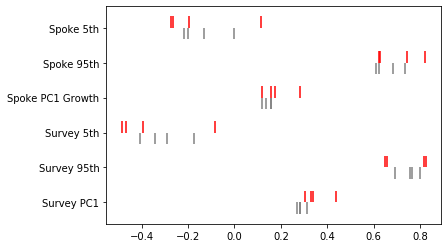

In [34]:
plt.vlines(spms['c_survey_pc1_variance'], ymin=0, ymax=1, color='grey')
plt.vlines(spms['t_survey_pc1_variance'], ymin=1, ymax=2, color='r')

plt.vlines(spms['c_survey_95th_similarity'], ymin=3, ymax=4, color='grey')
plt.vlines(spms['t_survey_95th_similarity'], ymin=4, ymax=5, color='r')

plt.vlines(spms['c_survey_5th_similarity'], ymin=6, ymax=7, color='grey')
plt.vlines(spms['t_survey_5th_similarity'], ymin=7, ymax=8, color='r')

plt.vlines(spms['c_spoke_pc1_growth'], ymin=9, ymax=10, color='grey')
plt.vlines(spms['t_spoke_pc1_growth'], ymin=10, ymax=11, color='r')

plt.vlines(spms['c_spoke_95th_similarity'], ymin=12, ymax=13, color='grey')
plt.vlines(spms['t_spoke_95th_similarity'], ymin=13, ymax=14, color='r')

plt.vlines(spms['c_spoke_5th_similarity'], ymin=15, ymax=16, color='grey')
plt.vlines(spms['t_spoke_5th_similarity'], ymin=16, ymax=17, color='r')



plt.yticks([1, 4, 7, 10, 13, 16], ['Survey PC1', 'Survey 95th', 'Survey 5th', 'Spoke PC1 Growth', 'Spoke 95th', 'Spoke 5th'])

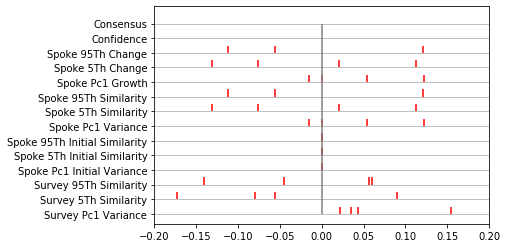

In [36]:
labels = []
ys = []
for i, key in enumerate(spms):
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        y = 2*i
        ys.append(y)
        plt.vlines(spms[key] - spms[control_key], ymin=y, ymax=y+1, color='r')
        labels.append(key.lstrip('t_').replace('_', ' ').title())
plt.yticks(ys, labels)
plt.xlim(-.2,.2)
plt.vlines(0, 0, max(ys), color='grey')
#plt.axis('off')
plt.grid(axis='y')

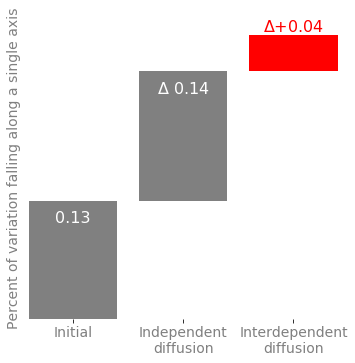

In [37]:
plt.figure(figsize=(5,5))

start = r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
control = r3.loc['spoke_pc1_variance']['Control Mean']
treatment = r3.loc['spoke_pc1_variance']['Treatment Mean']

plt.bar(x=[0,1,2], 
        height=[start,
                control-start, 
                treatment-control],
        bottom=[0, 
                start,
                control], 
        color=['grey', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 2.5)
plt.xticks([0,1,2], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

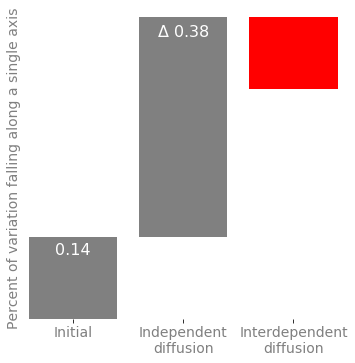

In [41]:
plt.figure(figsize=(5,5))

start = caveman_r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
control = caveman_r3.loc['spoke_pc1_variance']['Control Mean']
treatment = caveman_r3.loc['spoke_pc1_variance']['Treatment Mean']

plt.bar(x=[0,1,2], 
        height=[start,
                control-start, 
                treatment-control],
        bottom=[0, 
                start,
                control], 
        color=['grey', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 2.5)
plt.xticks([0,1,2], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

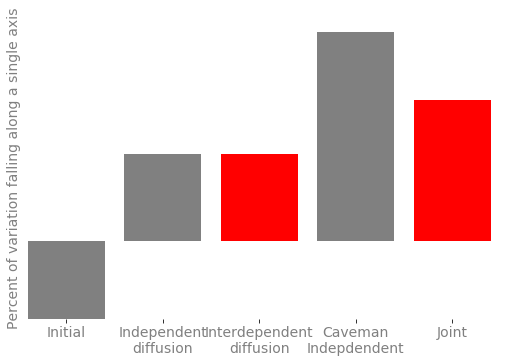

In [65]:
plt.figure(figsize=(7,5))

start = caveman_r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
caveman_control = caveman_r3.loc['spoke_pc1_variance']['Control Mean']
caveman_treatment = caveman_r3.loc['spoke_pc1_variance']['Treatment Mean']
control = r3.loc['spoke_pc1_variance']['Control Mean']
treatment = r3.loc['spoke_pc1_variance']['Treatment Mean']


plt.bar(x=[0,1,2,3,4], 
        height=[start,
                control-start, 
                treatment-start,
                caveman_control-start,
                caveman_treatment-start],
        bottom=[0, 
                start,
                start,
                start,
                start], 
        color=['grey', 'grey', 'r', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 4.5)
plt.xticks([0,1,2,3,4], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion',
                         'Caveman\nIndepdendent', 'Joint'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
#plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
#plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
#plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

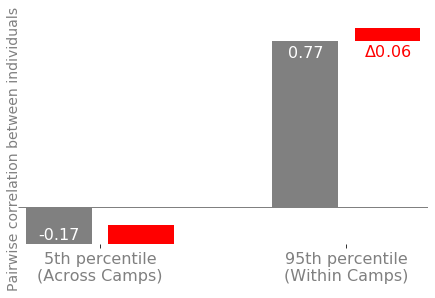

In [66]:

control_across = r3.loc['survey_5th_similarity']['Control Mean']
treatment_across = r3.loc['survey_5th_similarity']['Treatment Mean']
control_within = r3.loc['survey_95th_similarity']['Control Mean']
treatment_within = r3.loc['survey_95th_similarity']['Treatment Mean']

plt.bar(x=[0,1, 3,4], 
        height=[control_across, treatment_across-control_across, 
                control_within, treatment_within-control_within],
        bottom=[0, control_across, 0, control_within], 
        color=['grey', 'r', 'grey', 'r'])

plt.box(on=False)
plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.xlim(-.5, 4.5)
plt.xticks([0.5,3.5], ['5th percentile\n(Across Camps)', '95th percentile\n(Within Camps)'], ha='center', fontsize=16, color='grey');
plt.yticks([])

plt.text(0, control_across+.01, '%.02f'%control_across, 
         ha='center', va='bottom', color='white', fontsize=16)
plt.text(1, control_across+.01, '$\Delta$ %.02f'%(treatment_across-control_across), 
         ha='center', va='bottom', color='r', fontsize=16)
plt.text(3, control_within-.02, '%.02f'%control_within, 
         ha='center', va='top', color='white', fontsize=16)
plt.text(4, control_within-.01, '$\Delta$%.02f'%(treatment_within-control_within), 
         ha='center', va='top', color='r', fontsize=16)

plt.figtext(x=0, y=1, s='Pairwise correlation between individuals', 
            rotation=90, va='top', color='grey', fontsize=14)
plt.tight_layout()


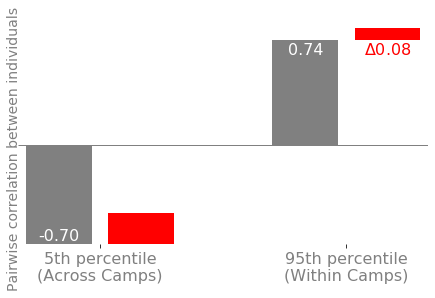

In [67]:
control_across = caveman_r3.loc['survey_5th_similarity']['Control Mean']
treatment_across = caveman_r3.loc['survey_5th_similarity']['Treatment Mean']
control_within = caveman_r3.loc['survey_95th_similarity']['Control Mean']
treatment_within = caveman_r3.loc['survey_95th_similarity']['Treatment Mean']

plt.bar(x=[0,1, 3,4], 
        height=[control_across, treatment_across-control_across, 
                control_within, treatment_within-control_within],
        bottom=[0, control_across, 0, control_within], 
        color=['grey', 'r', 'grey', 'r'])

plt.box(on=False)
plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.xlim(-.5, 4.5)
plt.xticks([0.5,3.5], ['5th percentile\n(Across Camps)', '95th percentile\n(Within Camps)'], ha='center', fontsize=16, color='grey');
plt.yticks([])

plt.text(0, control_across+.01, '%.02f'%control_across, 
         ha='center', va='bottom', color='white', fontsize=16)
plt.text(1, control_across+.01, '$\Delta$ %.02f'%(treatment_across-control_across), 
         ha='center', va='bottom', color='r', fontsize=16)
plt.text(3, control_within-.02, '%.02f'%control_within, 
         ha='center', va='top', color='white', fontsize=16)
plt.text(4, control_within-.01, '$\Delta$%.02f'%(treatment_within-control_within), 
         ha='center', va='top', color='r', fontsize=16)

plt.figtext(x=0, y=1, s='Pairwise correlation between individuals', 
            rotation=90, va='top', color='grey', fontsize=14)
plt.tight_layout()

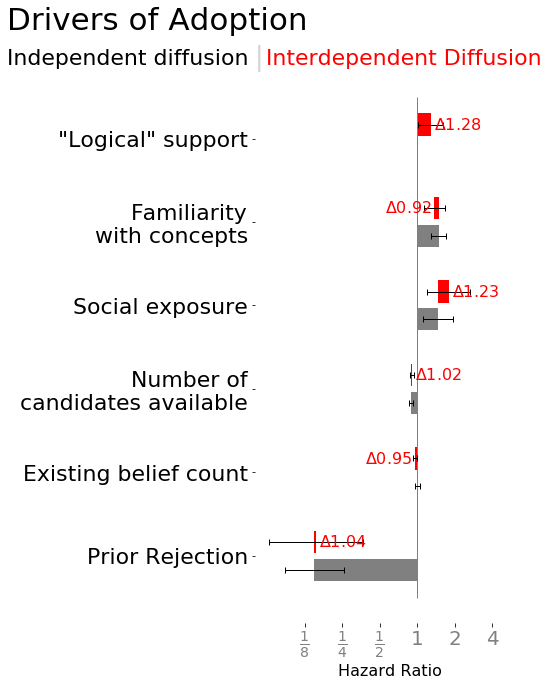

In [53]:
plt.figure(figsize=(8,10))
plt.rcParams["font.family"] = "san-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"


ctrl = ['in_deads', 'n_existing_beliefs', 'n_fresh_candidates', 'n_exposures', 'references']
trmt = ['treatment_in_deads', 'treatment_n_existing_beliefs', 'treatment_n_fresh_candidates', 
        'treatment_n_exposures', 'treatment_references', 'treatment_pl2']


ctrl_ys = np.arange(0, len(trmt)*3,3)
trmt_ys = ctrl_ys + 1

ctrl_width = list(r1['coef'].loc[ctrl])+[0]
trmt_diff =list(r1['coef'].loc[trmt])

ctrl_95 = log(r1[['lower .95', 'upper .95']].T[ctrl])
trmt_95 = log(r1[['lower .95', 'upper .95']].T[trmt])+ctrl_width

plt.barh(y=ctrl_ys, 
         width=ctrl_width,
         left=0, 
         color='grey')

plt.plot(ctrl_95, 
         [ctrl_ys[:-1], ctrl_ys[:-1]], 
         'k-|', linewidth=1, alpha=1)

plt.barh(y=trmt_ys, 
         width=trmt_diff,
         left=ctrl_width, 
         color='red')

plt.plot(trmt_95, 
         [trmt_ys, trmt_ys], 
         'k-|', linewidth=1, alpha=1)


plt.xlim(-3, 2)

labels = ['Prior Rejection', 'Existing belief count', 'Number of\ncandidates available',  
          'Social exposure', 'Familiarity\nwith concepts', '"Logical" support']
plt.yticks(np.arange(0.5, len(trmt)*3, 3), labels, fontsize=22)
plt.xticks(np.log([.125, .25,.5,1,2,4]), [r'$\frac{1}{8}$', r'$\frac{1}{4}$',r'$\frac{1}{2}$',1,2,4], 
           fontsize=20, color='grey')
plt.xlabel('Hazard Ratio', fontsize=16)

plt.vlines(0, -1, len(trmt)*3-1, linewidth=1, color='grey')
plt.box(False)


for td, cw, y in zip(trmt_diff, ctrl_width, trmt_ys):
    xp = td + cw + .05 * np.sign(td)
    plt.text(#xp, y, '$\Delta$%s%.02f'%('+' if td>=0 else '', exp(td)-1), 
             xp, y, '$\Delta$%.02f'%(exp(td)), 
             ha='left' if td>0 else 'right', 
             va='center', color='r', fontsize=16, alpha=1)



plt.suptitle('Drivers of Adoption', x=0, ha='left', fontsize=31)
plt.figtext(x=0, y=.9, s='Independent diffusion',  ha='left', fontsize=22)
plt.figtext(x=.43, y=.9, s='|',  ha='left', fontsize=26, color='lightgrey')
plt.figtext(x=.45, y=.9, s='Interdependent Diffusion',  ha='left', fontsize=22, color='r')


plt.subplots_adjust(top=.89, left=.43)
# plt.savefig('/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Thesis/drivers_of_adoption_logic_0.png', dpi=150)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


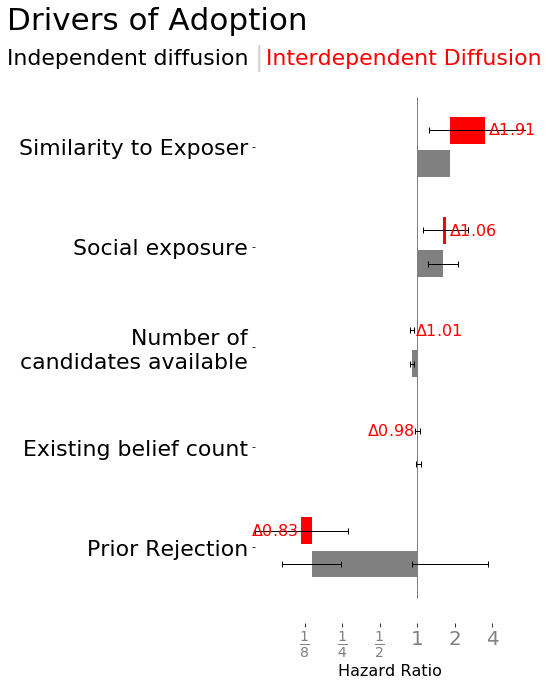

In [54]:
plt.figure(figsize=(8,10))
plt.rcParams["font.family"] = "san-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"


ctrl = ['in_deads', 'n_existing_beliefs', 'n_fresh_candidates', 'n_exposures', 'max_similarity_to_exposer']
trmt = ['treatment_in_deads', 'treatment_n_existing_beliefs', 'treatment_n_fresh_candidates', 
        'treatment_n_exposures', 'treatment_max_similarity_to_exposer']


ctrl_ys = np.arange(0, len(trmt)*3,3)
trmt_ys = ctrl_ys + 1

ctrl_width = list(r2['coef'].loc[ctrl])
trmt_diff =list(r2['coef'].loc[trmt])

ctrl_95 = log(r2[['lower .95', 'upper .95']].T[ctrl])
trmt_95 = log(r2[['lower .95', 'upper .95']].T[trmt])+ctrl_width

plt.barh(y=ctrl_ys, 
         width=ctrl_width,
         left=0, 
         color='grey')

plt.plot(ctrl_95, 
         [ctrl_ys[:-1], ctrl_ys[:-1]], 
         'k-|', linewidth=1, alpha=1)

plt.barh(y=trmt_ys, 
         width=trmt_diff,
         left=ctrl_width, 
         color='red')

plt.plot(trmt_95, 
         [trmt_ys, trmt_ys], 
         'k-|', linewidth=1, alpha=1)


plt.xlim(-3, 2)

labels = ['Prior Rejection', 'Existing belief count', 'Number of\ncandidates available',  
          'Social exposure', 'Similarity to Exposer']
plt.yticks(np.arange(0.5, len(trmt)*3, 3), labels, fontsize=22)
plt.xticks(np.log([.125, .25,.5,1,2,4]), [r'$\frac{1}{8}$', r'$\frac{1}{4}$',r'$\frac{1}{2}$',1,2,4], 
           fontsize=20, color='grey')
plt.xlabel('Hazard Ratio', fontsize=16)

plt.vlines(0, -1, len(trmt)*3-1, linewidth=1, color='grey')
plt.box(False)


for td, cw, y in zip(trmt_diff, ctrl_width, trmt_ys):
    xp = td + cw + .05 * np.sign(td)
    plt.text(#xp, y, '$\Delta$%s%.02f'%('+' if td>=0 else '', exp(td)-1), 
             xp, y, '$\Delta$%.02f'%(exp(td)), 
             ha='left' if td>0 else 'right', 
             va='center', color='r', fontsize=16, alpha=1)



plt.suptitle('Drivers of Adoption', x=0, ha='left', fontsize=31)
plt.figtext(x=0, y=.9, s='Independent diffusion',  ha='left', fontsize=22)
plt.figtext(x=.43, y=.9, s='|',  ha='left', fontsize=26, color='lightgrey')
plt.figtext(x=.45, y=.9, s='Interdependent Diffusion',  ha='left', fontsize=22, color='r')


plt.subplots_adjust(top=.89, left=.43)
# plt.savefig('/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Thesis/drivers_of_adoption_logic_0.png', dpi=150)


# open responses

In [13]:
def process_open_responses(process_games):
    
    count = 0
    fair = []
    length = []
    feedback = []
    t_idle = []
    c_idle = []
    
    for game in process_games:
        
        for player_id, player in game['players'].items():
            count +=1
        
        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'fair' in player['data.survey'].keys():
                    s = player['data.survey']['fair']
                    fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'time' in player['data.survey'].keys():
                    s = player['data.survey']['time']
                    length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'feedback' in player['data.survey'].keys():
                    s = player['data.survey']['feedback']
                    feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
                    
        for player_id, player in game['players'].items():
            if 'data.active' in player.keys():
                if player['data.position'].startswith('t'):
                    t_idle.append(player['data.active'])
                elif player['data.position'].startswith('c'):
                    c_idle.append(player['data.active'])


                    
    return (pd.DataFrame(pd.Series(fair).value_counts()), 
            pd.DataFrame(pd.Series(length).value_counts()), 
            pd.DataFrame(pd.Series(feedback).value_counts()),
            pd.DataFrame(pd.Series(t_idle).value_counts()),
            pd.DataFrame(pd.Series(c_idle).value_counts()),
            count
           )

fair, length, feedback, t_idle, c_idle, count = process_open_responses(process_games)

In [10]:
pd.options.display.max_rows = 999
fair

,0
yes,158
yes,4
yes very fair,4
no,3
yes very,3
yeah,3
very fair,2
yes thank you,2
more than fair,2
definitely fair,1


In [49]:
length

,0
yes,133
yes i did,4
yes,3
yeah,2
yes more than enough,2
no,2
yes too much time,1
i think so,1
enough time,1
more than enough time,1


In [12]:
pd.options.display.max_rows = 999
feedback

,0
,48
none,35
na,4
no problems,4
no issues,4
i did not encounter any problems,2
thank you,2
fun survey,2
none thanks,2
no problems encountered,2


In [51]:
t_idle

,0
idle once,20


In [52]:
c_idle

,0
idle once,24
